In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
import zipfile
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# Define the path to the zip file and the directory to extract to
zip_file_path = 'Plant_leaf_diseases_dataset_with_augmentation.zip'
extract_dir = 'Plant_leave_diseases_dataset_with_augmentation'


In [3]:

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

NameError: name 'zip_file_path' is not defined

In [5]:
'i wanna increase the'


class_names = sorted(os.listdir(extract_dir))
def process_path(file_path):
    # Get the label from the directory name
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    label = tf.where(class_names == label)[0][0]
    
    # Load and preprocess the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0  # Normalize to [0,1] range
    
    return img, label

In [6]:
# List the classes
class_names = sorted(os.listdir(extract_dir))

# Create a dataset of file paths
list_ds = tf.data.Dataset.list_files(f'{extract_dir}/*/*', shuffle=True)

# Split into train and validation sets
val_size = int(0.2 * len(list(list_ds)))
train_size = len(list(list_ds)) - val_size

train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size).take(val_size)

# Map the process_path function to the datasets
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)


In [7]:
# Print the number of class names
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 39
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot'

In [8]:
batch_size = 32

train_ds = train_ds.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Add Dropout layer for regularization
predictions = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs = base_model.input, outputs = predictions)



# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Print the summary of custom layers
custom_layers_start = len(base_model.layers)
for layer in model.layers[custom_layers_start:]:
    print(f"Layer: {layer.name}")
    print(f"  Input shape: {layer.input_shape}")
    print(f"  Output shape: {layer.output_shape}")
    print("\n")

Layer: global_average_pooling2d_2
  Input shape: (None, 7, 7, 1280)
  Output shape: (None, 1280)


Layer: batch_normalization_2
  Input shape: (None, 1280)
  Output shape: (None, 1280)


Layer: dense_4
  Input shape: (None, 1280)
  Output shape: (None, 1024)


Layer: dropout_2
  Input shape: (None, 1024)
  Output shape: (None, 1024)


Layer: dense_5
  Input shape: (None, 1024)
  Output shape: (None, 39)




In [21]:


# Optionally, unfreeze some layers and fine-tune
base_model.trainable = False
fine_tune_at = 100



In [22]:
len(model.trainable_variables)

6

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

In [9]:
test_loss, test_accuracy = model.evaluate(val_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

385/385 [==============================] - 8s 20ms/step - loss: 0.0799 - accuracy: 0.9765
Test Loss: 0.07988762110471725
Test Accuracy: 0.9764983057975769


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [10]:
import random
from matplotlib import pyplot as plt

# Assuming the previous steps to create datasets and train the model are done
# Save the trained model
model.save('plant_disease_model.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('plant_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='plant_disease_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()




INFO:tensorflow:Assets written to: C:\Users\Jinniu\AppData\Local\Temp\tmpatwrl871\assets


INFO:tensorflow:Assets written to: C:\Users\Jinniu\AppData\Local\Temp\tmpatwrl871\assets


In [11]:
# Print input and output shapes
print(f'Input shape: {input_details[0]["shape"]}')
print(f'Output shape: {output_details[0]["shape"]}')
print(f'Input type: {input_details[0]["dtype"]}')  # Print input type
print(f'Output type: {output_details[0]["dtype"]}')  # Print output type

Input shape: [  1 224 224   3]
Output shape: [ 1 39]
Input type: <class 'numpy.float32'>
Output type: <class 'numpy.float32'>


In [12]:


def predict_tflite(image):
    interpreter.set_tensor(input_details[0]['index'], [image])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return np.argmax(output[0])

# Randomly pick 40 images from each folder in the test set
test_samples = []
test_labels = []
for class_name in class_names:
    class_dir = os.path.join(extract_dir, class_name)
    img_paths = random.sample(os.listdir(class_dir), 100)
    for img_path in img_paths:
        img = tf.keras.preprocessing.image.load_img(os.path.join(class_dir, img_path), target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1] range
        test_samples.append(img)
        test_labels.append(class_names.index(class_name))

test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

# Evaluate the TFLite model
correct_predictions = np.zeros(len(class_names))
total_predictions = np.zeros(len(class_names))

for img, label in zip(test_samples, test_labels):
    predicted_label = predict_tflite(img)
    total_predictions[label] += 1
    if predicted_label == label:
        correct_predictions[label] += 1

# Calculate accuracy for each class
class_accuracies = correct_predictions / total_predictions * 100



In [13]:
# Print class accuracies
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f'Class {class_name} Accuracy: {accuracy:.2f}%')

# Calculate and print average accuracy
average_accuracy = np.mean(class_accuracies)
print(f'Average Accuracy: {average_accuracy:.2f}%')

Class Apple___Apple_scab Accuracy: 95.00%
Class Apple___Black_rot Accuracy: 100.00%
Class Apple___Cedar_apple_rust Accuracy: 100.00%
Class Apple___healthy Accuracy: 99.00%
Class Background_without_leaves Accuracy: 99.00%
Class Blueberry___healthy Accuracy: 99.00%
Class Cherry___Powdery_mildew Accuracy: 98.00%
Class Cherry___healthy Accuracy: 98.00%
Class Corn___Cercospora_leaf_spot Gray_leaf_spot Accuracy: 95.00%
Class Corn___Common_rust Accuracy: 99.00%
Class Corn___Northern_Leaf_Blight Accuracy: 96.00%
Class Corn___healthy Accuracy: 99.00%
Class Grape___Black_rot Accuracy: 100.00%
Class Grape___Esca_(Black_Measles) Accuracy: 98.00%
Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot) Accuracy: 100.00%
Class Grape___healthy Accuracy: 100.00%
Class Orange___Haunglongbing_(Citrus_greening) Accuracy: 100.00%
Class Peach___Bacterial_spot Accuracy: 99.00%
Class Peach___healthy Accuracy: 98.00%
Class Pepper,_bell___Bacterial_spot Accuracy: 97.00%
Class Pepper,_bell___healthy Accuracy: 96.00%
Cl

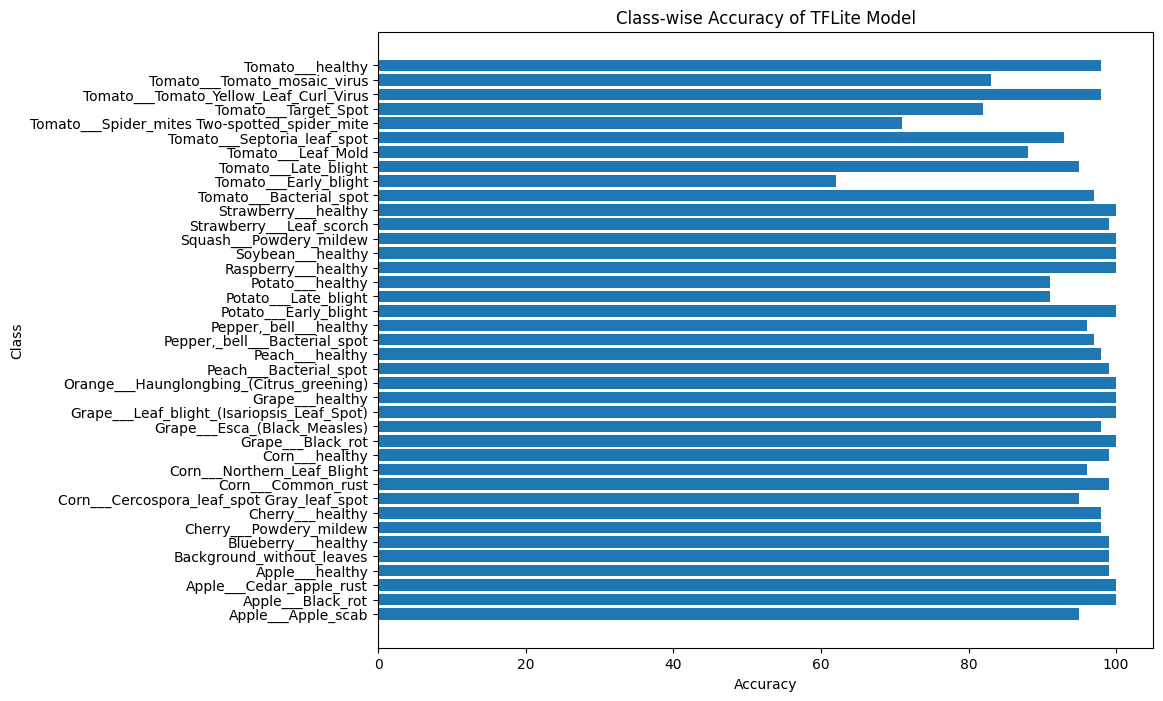

In [14]:
# Plot the class accuracies
plt.figure(figsize=(10, 8))
plt.barh(class_names, class_accuracies)
plt.xlabel('Accuracy')
plt.ylabel('Class')
plt.title('Class-wise Accuracy of TFLite Model')
plt.show()